## AC209a project - clean and visualize calendar.csv ##


In [1]:
import pandas as pd
import time
from langdetect import detect
import goslate
from matplotlib import dates
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import scipy as sp
from scipy.stats import mode

%matplotlib inline

## Data cleaning for calendar1.csv ##
- Solve "2,000" or "1,400" case (with ',' same as delimiter)
- convert date string to number
- remove unavailabe listings


In [2]:
# read data
calendar = pd.read_csv('./Data/calendar1.csv', delimiter = ',')

# check data
calendar.head()


,listing_id,date,available,price,etc
0,3604481,2015-01-01,t,$600.00,NaN
1,3604481,2015-01-02,t,$600.00,NaN
2,3604481,2015-01-03,t,$600.00,NaN
3,3604481,2015-01-04,t,$600.00,NaN
4,3604481,2015-01-05,t,$600.00,NaN


In [3]:
# check entries in original data
calendar.shape

(9998080, 5)

In [91]:
# --------------
# clean up price
# --------------

# get only available entries
available = pd.DataFrame(calendar[calendar["available"] == "t"])

# insert a column to store cleaned price
available.insert(3, "price_cleaned", np.zeros((available.shape[0],1)))

# convert price string to number
available["price"]=available["price"].map(lambda x: x.lstrip("$"))
available["price"] = available["price"].apply(pd.to_numeric)

# find indices for price < 1000 and >= 1000
index_low = available[pd.isnull(available["etc"])].index
index_high = available[pd.notnull(available["etc"])].index

# clean up price and store in price_cleaned
available.loc[index_low,"price_cleaned"]=available.loc[index_low,"price"]
available.loc[index_high,"price_cleaned"]=available.loc[index_high,"price"]*1000 + available.loc[index_high,"etc"]

# remove columns "price" and "etc"
available.drop("etc", axis=1, inplace=True)
available.drop("price", axis=1, inplace=True)

# save to csv
available.to_csv('./Data/calendar_cleaned.csv', delimiter = ',')

In [64]:
# check how many entries are left
print available.shape

(7201883, 5)


In [109]:
# remove columns "price" and "etc"
available.drop("etc", axis=1, inplace=True)
available.drop("price", axis=1, inplace=True)

# save to csv
available.to_csv('./Data/calendar_cleaned.csv', delimiter = ',', index = False)

## Data exploration ##

In [3]:
# read data
data = pd.read_csv('./Data/calendar_cleaned.csv', delimiter = ',')

# check data
data.head()


,listing_id,date,available,price_cleaned
0,3604481,2015-01-01,t,600.0
1,3604481,2015-01-02,t,600.0
2,3604481,2015-01-03,t,600.0
3,3604481,2015-01-04,t,600.0
4,3604481,2015-01-05,t,600.0


In [4]:
print 'Total number of postings in data: ' + str(data.shape[0])

Total number of postings in data: 7201883


In [5]:
# parse year, month, and day
data['date'] = pd.to_datetime(data['date'])
data['year'], data['month'], data['day'] = \
data['date'].dt.year, data['date'].dt.month, data['date'].dt.day


In [6]:
# select year 2015 data
index_2015 = data[data['year'] == 2015].index
data_2015 = pd.DataFrame(data.loc[index_2015])
data_2015.head()

,listing_id,date,available,price_cleaned,year,month,day
0,3604481,2015-01-01,t,600.0,2015,1,1
1,3604481,2015-01-02,t,600.0,2015,1,2
2,3604481,2015-01-03,t,600.0,2015,1,3
3,3604481,2015-01-04,t,600.0,2015,1,4
4,3604481,2015-01-05,t,600.0,2015,1,5


### Check postings vs month ###

In [12]:
# count postings vs month
np_mon = np.array(data_2015['month'])
np_mon_count = np.zeros((12,))

for idx_mon in range(12):
    np_mon_count[idx_mon] = np.sum(np_mon == (idx_mon + 1))


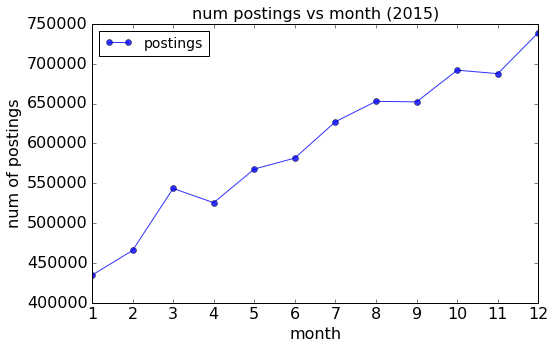

In [13]:
# plot postings vs month
matplotlib.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(1,13,1), np_mon_count, 'bo-', label = 'postings', alpha = 0.8)
ax.set_xlabel('month', fontsize=16)
ax.set_ylabel('num of postings', fontsize=16)
ax.set_title('num postings vs month (2015)', fontsize=16)
ax.set_xlim([1,12])
plt.xticks(range(1,13,1))
plt.legend(loc = 2, fontsize = 14)
plt.show() 

### Check postings vs price ###

In [65]:
# check price distribution
np_price = np.array(data_2015['price_cleaned'])

price_cat = [0, 75, 150, 300, 10000]
np_price_count = np.zeros(len(price_cat) - 1)

for idx_price in range(len(price_cat) -1):
    
    np_price_count[idx_price] = np.sum(np.multiply(np_price > price_cat[idx_price], \
                                                   np_price <= price_cat[idx_price + 1]))
 

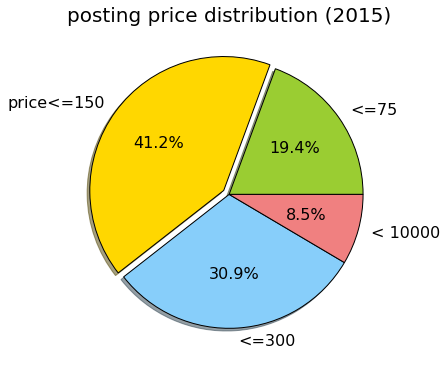

In [81]:
# plot povstings price distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

labels = ['<=75', 'price<=150', '<=300', '< 10000']
fracs = np_price_count/len(np_price)
explode= [0, 0.05, 0, 0]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

ax.pie(fracs, explode=explode, labels=labels, colors=colors,
                autopct='%1.1f%%', shadow=True, startangle=0)

ax.set_title('posting price distribution (2015)', fontsize=20)

plt.show()

### Check postings and price by listing_id ###

In [17]:
# --------------
# check postings and price by listing_id
# --------------
# group data by listing_id
grouped_id = data_2015.groupby('listing_id')
# get a pandas series of id_size
id_size = grouped_id.size()

# get group size by id
size_by_id = id_size.values

# get mean price by id
grouped_mean = grouped_id.mean()
price_by_id = grouped_mean['price_cleaned'].values


In [18]:
# print total number of listing_id
print 'Total number of listing_id: ' + str(len(grouped_id.size()))

Total number of listing_id: 26622


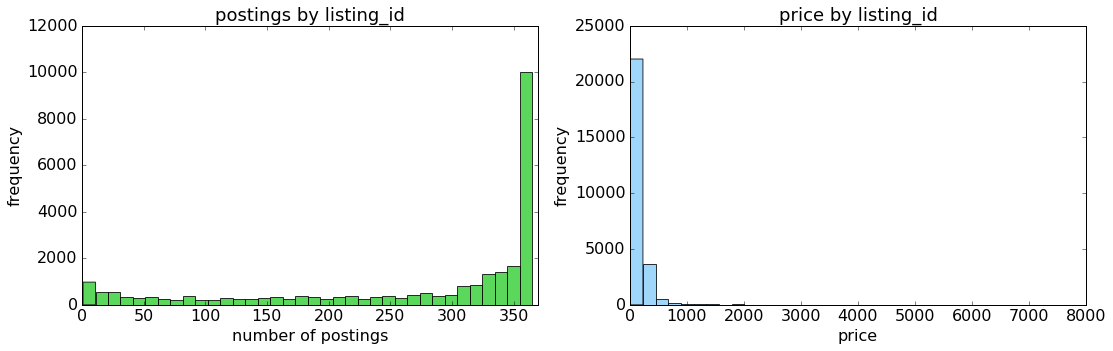

In [31]:
# plot listing_id data
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# plot postings by listing_id
ax[0].hist(size_by_id, bins=36, color='limegreen', alpha=0.8)

ax[0].set_xlabel('number of postings', fontsize=16)
ax[0].set_ylabel('frequency', fontsize=16)
ax[0].set_title('postings by listing_id', fontsize=18)
ax[0].set_xlim([0,370])

# plot postings by listing_id
ax[1].hist(price_by_id, bins=36, color='lightskyblue', alpha=0.8)

ax[1].set_xlabel('price', fontsize=16)
ax[1].set_ylabel('frequency', fontsize=16)
ax[1].set_title('price by listing_id', fontsize=18)


### Check price vs month ###

In [7]:
# --------------
# check price by month
# --------------
# group data by month
grouped_mon = data_2015.groupby('month')
# get a pandas series of id_size
mon_size = grouped_mon.size()

# get group size by mon
size_by_mon = mon_size.values

# get mean price by mon
grouped_mon_mean = grouped_mon.mean()
price_by_mon = grouped_mon_mean['price_cleaned'].values


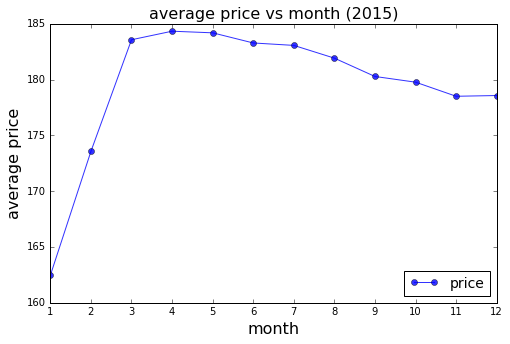

In [11]:
# plot price vs month
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(range(1,13,1), price_by_mon, 'bo-', label = 'price', alpha = 0.8)
ax.set_xlabel('month', fontsize=16)
ax.set_ylabel('average price', fontsize=16)
ax.set_title('average price vs month (2015)', fontsize=16)
ax.set_xlim([1,12])
plt.xticks(range(1,13,1))
plt.legend(loc = 4, fontsize = 14)
plt.show() 